# Long Short Term Memory
## A simple guide using keras library 

In this tutorial we will use supernova simulations to train a Recurren Neural Network using LSTM units.

In [10]:
import h5py
import tensorflow.keras as keras 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd
import tensorflow as tf

### Load data

In [11]:
filename = './data/supernovae.hdf5'
f = h5py.File(filename, 'r')
light_curves = f['curves'][()]
labels       = f['labels'][()]
ids          = f['sne_id'][()]

I = [1,3,32,33]
labels_new = np.array([0 if l in I else 1 for l in labels ])
multi_class = {1: 0, 2:1, 3:2, 21:3, 22:4, 23:5, 32:6, 33:7}
labels     = np.array([multi_class[l] for l in labels])

<img src="./img/sne_types.png" alt="Girl in a jacket" width="350" height="400"> 

Supernova classes are very unbalanced. A faster way is to group by parent class; It means that we are going to transform a multiclass problem into a binary one.

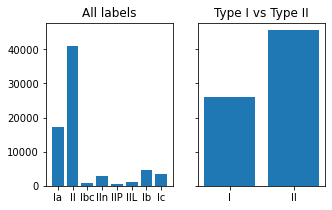

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(5,3), sharey=True)

# (labels, class names, figure title)
multi_tuple = (labels, ['Ia', 'II', 'Ibc', 'IIn', 'IIP', 'IIL', 'Ib', 'Ic'], 'All labels')
binar_tuple = (labels_new, ['I', 'II'], 'Type I vs Type II')

for index, (y_vector, cls_names, title) in enumerate([multi_tuple, binar_tuple]):
    values, counts = np.unique(y_vector, return_counts=True)
    x_range = np.arange(len(values))
    axes[index].bar(x_range,counts)
    axes[index].set_title(title)
    axes[index].set_xticks(x_range)
    axes[index].set_xticklabels(cls_names)
    
plt.show()

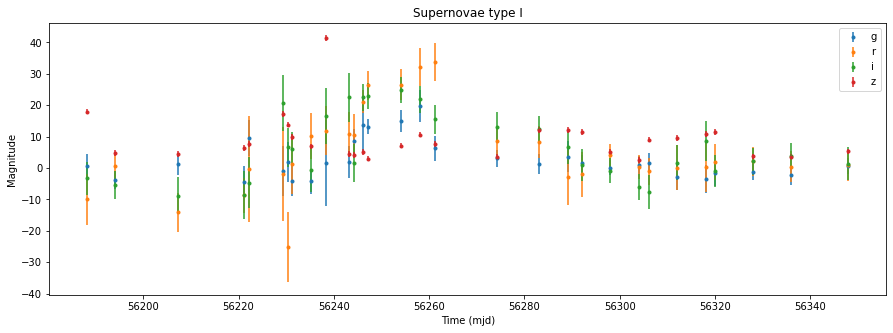

In [13]:
selected = light_curves[labels_new == 0][0]
plt.figure(figsize=(15,5))

for i, passband in enumerate(['g', 'r', 'i', 'z']):
    plt.errorbar(selected[:,0], 
                 selected[:,i+1], 
                 yerr=selected[:,i+5], 
                 label=passband, 
                 fmt='.')

plt.legend()
plt.xlabel('Time (mjd)')
plt.ylabel('Magnitude')
plt.title('Supernovae type I')
plt.show()

## Data Preprocessing 

In order to avoid the vanish or explode gradient problem we need to scale our data. Preprocessing package from scikit-learn provide a StandarScaler class which normalize the data using the mean and standar deviation for each feature.
<br><br><center>$
\hat{x} = \frac{x - \bar{x}}{\sigma_x}
$<center>

In [14]:
x_scaled = light_curves-np.mean(light_curves, 1)[:, None]
y_onehot = pd.get_dummies(labels_new).values
np.unique(y_onehot, axis=0)

array([[0, 1],
       [1, 0]], dtype=uint8)

#### Split data to perform training 

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_rest, y_train, y_rest = train_test_split(x_scaled, y_onehot, test_size=0.3, random_state=42, shuffle=True)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42, shuffle=True)

print('Train dimensionality: {}\nTest dimensionality:  {}'.format(x_train.shape, x_test.shape))

Train dimensionality: (50137, 30, 9)
Test dimensionality:  (10744, 30, 9)


In [17]:
def create_dataset(x, y, batch_size=50):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.padded_batch(batch_size)
    return dataset

In [18]:
train_dataset = create_dataset(x_train, y_train)
val_dataset   = create_dataset(x_val, y_val)
test_dataset  = create_dataset(x_test, y_test)

2022-07-31 15:01:54.592379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-31 15:01:54.592449: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-31 15:01:54.592544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (appa): /proc/driver/nvidia/version does not exist
2022-07-31 15:01:54.593162: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Long Short Term Memory

Using ```Sequential()``` class from *Keras Library* we can stack several layers. In this case, we will use recurrent and dense layer for *the middle learning* and dense activated layer for the output. Remember that the output should have the same dimension as number of classes are considered.<br><br>A graphical representation is shown bellow 

<img src="./img/archi.png" alt="Girl in a jacket" width="700" height="400"> 

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, LSTM, Dropout, Input
from keras.callbacks import EarlyStopping

In [20]:
# Params 
batch_size   = 128 # Training batch size
n_steps      = x_train.shape[1] # Number of time steps into the serie 
n_channels   = x_train.shape[2] # Number of attributes such as magnitudes and errors
n_classes    = np.unique(labels_new).shape[0] 

n_neurons    = 16  # Neurons in each gate of LSTM

dropout_prob = 0.2 # Fraction of the units to drop 
n_epochs     = 10  # Max number of epochs on training
patience     = 5   # Number of epochs with no improvement

In [21]:
inputs = Input(shape=(n_steps, n_channels))

x = LSTM(n_neurons, return_sequences=True, dropout=dropout_prob)(inputs)
x = LSTM(n_neurons, dropout=dropout_prob)(x)
x = Dense(n_neurons, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=[inputs], outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 30, 16)            1664      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 4,082
Trainable params: 4,082
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(train_dataset, 
                    epochs=n_epochs, 
                    validation_data=val_dataset,
                    callbacks = [EarlyStopping(patience=patience)])

Epoch 1/10
1003/1003 [==============================] - 15s 13ms/step - loss: 0.3333 - acc: 0.8584 - val_loss: 0.2183 - val_acc: 0.9208
Epoch 2/10
 299/1003 [=======>......................] - ETA: 8s - loss: 0.2528 - acc: 0.8998

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
y_probas = model.predict(x_test)
y_pred   = np.argmax(y_probas, axis=1)
y_true   = np.argmax(y_test, axis=1)
acc_test = accuracy_score(y_true, y_pred)
f1_score = f1_score(y_true, y_pred, average='macro') 
print('Accuracy:{}\nF1:{}'.format(acc_test, f1_score))

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from visual import plot_confusion_matrix
class_names = ['I', 'II']
cnf_matrix = confusion_matrix(y_true, y_pred)
# Plot non-normalized confusion matrix
plt.figure(figsize=(17,8))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')